# Part 1: Introduction to MCMC and emcee

In this notebook we will go over what MCMC means and what exactly is it that is going on when we run an MCMC algorithm such as Metropolist-Hasting or a code like emcee. 

## What is MCMC?

Markov Chain Monte Carlo (MCMC) is a class of algorithms used to sample from a probability distribution. It is particularly useful when dealing with high-dimensional spaces where traditional sampling methods are inefficient. MCMC methods construct a Markov chain that has the desired distribution as its equilibrium distribution. By simulating the Markov chain, we can obtain samples from the target distribution. As astronomers we do a lot of work trying to estimate physical paramters on astrophysical sources such as stars, galaxies and cosmology. Most of the time the target distribution we are after is getting a handle on the parameters for a certain model and the uncertainties on those parameters. MCMC comes in handy to sample the parameter spaces for these complex models and allows us to see how constrained certain parameters are. 

### Key Concepts

- **Markov Chain**: A sequence of random variables where the distribution of each variable depends only on the state of the previous one.
- **Monte Carlo**: Refers to the use of random sampling to estimate numerical results.
- **Equilibrium Distribution**: The distribution to which the Markov chain converges after a large number of steps. In the Bayesian context this equilibrium distribution is the *Posterior* Distribution which we will cover later in this notebook.

### Common MCMC Algorithms

- **Metropolis-Hastings**: A widely used MCMC algorithm that generates a sequence of samples by proposing moves to new states and accepting or rejecting them based on a certain probability.
- **Gibbs Sampling**: A special case of the Metropolis-Hastings algorithm where each variable is sampled from its conditional distribution given the current values of the other variables.

### Applications

MCMC methods are used in various fields such as:

- Bayesian statistics for posterior distribution sampling
- Computational physics for simulating systems with many degrees of freedom
- Machine learning for training models with complex likelihood functions


# Why do we use MCMC to begin with? 

# Introducing Bayesian Statistics

The reason why we go ahead and use MCMC to begin with is because we are using a Bayesian framework to understand the features we are studying. To start our Bayesian journey we need to go over the main equation that is driving Bayesian Statistics forward, Bayes Theorem:

$P(\theta | x) = \frac{P(x|\theta)P(\theta)}{P(x)}$

Let us unpack the above equation:

$P(\theta|x)$ is the probability of acquiring certain parameters $\theta$ provided the data, $x$ and the quantity we are after. In Bayesian terms this is the *Posterior* Distribution. $P(x|\theta)P(\theta)$ is a combination of the *likelihood* function $P(x|\theta)$, which is the probability of acquiring the data for a set of input quantities $\theta$ and $P(\theta)$ is the *prior* which is the probability of getting those parameters.

The denominator is the total probability of acquiring the data, a way to get this is by integrating over all possible values of $\theta$:

$P(x) = \int P(x, \theta) d\theta$

However, this integral is non-trivial to solve most of the time. This is reason why we use MCMC, as a way to get back the posterior distribution we are interested in. This is achieved because the Posterior distribution can be *approximated* by the product of the likelihood and prior. 

This can be seen in Bayes Theorem where if we ignore the denominator the Posterior distribution goes as: 

$P(\theta | x) \approx P(x|\theta)p(\theta)$


We will exploit this feature of approximating the posterior by the product of Likelihood and Prior below.

# How does MCMC work?
 
The first thing we have to do when starting MCMC is to provide an MCMC algorithm with an initial guess on the parameters we are interested in. Then you propose a move jump from the starting point to another point, these jumps can be as simple or complex as you want. Let us say for the sake of this example that you propose a jump that is a normal distribution centered at 0 and has a standard deviation of 1. So let us take our starting value as 1, the jumps we can take can be anything within the x-values as shown in the plot below:

![alt text](jump_norm.png "jumps")

We can see the normal distribution above and the x-values are the potential jumps that we can take and the probability of jumping to those x-values are shown on the y-axis. This means that a jump value of 0 is more likely than any other jumps. 

So let us say that we drew a jump value of -0.5 that means that we will take the current value update it with a value of -0.5 by adding it to our current value and that will give us another value, -0.5 in this case. We then see if this new value that we are at is better than the previous value we were at. 

So how do we quantify this as a better value?

The way we do this is by comparing the likelihood of getting that parameter against the priors on that parameters and we see which parameter has a higher value. We then take the ratio of the two likelihoods and then we will accept the new value if this ratio is higher than a random value drawn between 0 and 1. If it is then we accept the jump, if it is not then we stay at the current value and do another jump to a different value. Then we repeat this process until the parameters converge. 

These values that jump from one value to another have a term for them called "walkers". Their role is to explore or walk around the parameter space to explore the values that have the highest likelihood.

Things to note about the jumps to look out for:

- The jump size is something that can take some fine tuning because you want the jumps to be distinct from the current value but you do not want to take too big of a jump that you miss out on values. 


In Short: 

1. Provide an intitial guess on the parameters
2. propose a jump condition from the initial guess
3. compare the new value to the old value by comparing their likelihoods
4. Apply randomness by comparing the ratio of the likelihoods to a random number between 0-1
    a. If likelihod ratio is greater than this random number we accept the new value
    b. If it is not we stay at the current value
5. Repeat steps 2-4 for some time until the walkers have converged
6. You can now analyze the distribution of values 


# Example with emcee: Fitting a Line

We will go over implimenting MCMC using a package called emcee in the cells below. We will go over some of the basic frameowrk of MCMC using a simple example of fitting a line to some data and then in Part 3 we will expand upon this by fitting a Gaussian model to the data.

# Step 0: Generating the data that we are trying to fit

The data we are going to try to fit is a set of data that has a linear relation. That is a function that has the form:

y = mx + b

The parameters that we are going to try to fit are the slope (m) and y-intercept (b). Let us generate the data and add some noise to them so the data do not lie exactly on a line. 

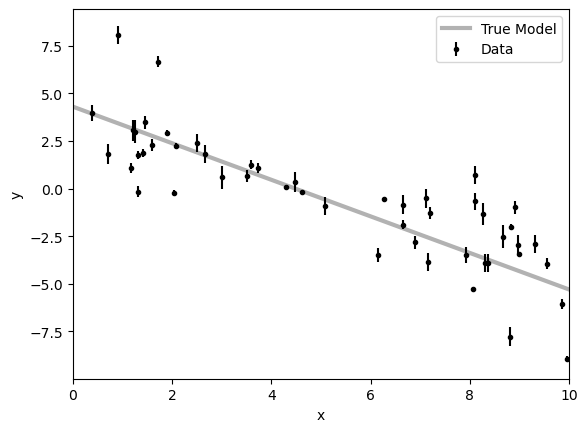

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(134)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label = 'Data')
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label = 'True Model')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Step 1: Generate Likelihood Function

The first step we need to do when using emcee is start with a likelihood function. This function encapsulates how likely a model can match to the data. One of the ways that we do this is by using a version of the $\chi^2$ goodness of fit criteria as our likelihood function. We want a function that can find the smallest difference between the data and the model, which a $\chi^2$ can do as the functional form for that is:

$\chi^2 = \sum_1^N \frac{(y - f(\theta))^2}{\sigma^2}$

In the above equation N is the number of data points you are fitting, y is the y-data, f($\theta$) is the model for a given $\theta$ value and $\sigma$ is the error on the y-data. 

For this example, and all real world example, the model will almost never cross through all the data even with the inclusion of the errors so one thing we will add is a fudge factor to take this into account. This fudge factor will be another parameter that we are fitting and will show up in our likelihood calculations as shown below.

For our likelihood function below we are going to assume gaussian errors and as a result this will add another term into the likelihood function. Our final likelihood is actually going to be:

$log(L) = 0.5  \sum_1^N \frac{(y - f(\theta))^2}{\sigma^2} + ln(\sigma_2)$

Where:

$\sigma_2 = \sigma + f(\theta)* e^{2ln(f)}$

So in a sense we are scaling the errors by an additional factor determined by the fudge factor $ln(f)$. $\sigma$ is the y-error and $f(\theta)$ is the model for the given set of parameters $\theta$.

In [ ]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# Step 2: Making the Prior Function

Now that we have made the Likelihood function, we can move ahead and make our prior function. This prior will restrict the parameter bounds if we need them to. This function will ensure that the parameters explores within MCMC and emcee stay within the bounds determined by the prior. 

## Why do we need priors?

Sometimes priors are needed to help MCMC codes and algorithms to efficiently explore the parameter spaces we are interested. By default, if no priors are provided, the walkers can explore every possible value in the parameter space even if the value for that parameter may be unphysical or not possible. 

For example, if you have a model and one of the parameters is mass, we know that mass is always positive. So one easy prior to impose is to ensure that mass always stays positive, providing a lower limit to mass you have eliminated half of the parameter space. 

You can also use astrophysical knowledge to construct what an upper limit would be. If you are working with a code to estimate galaxy masses you can use your knowledge of galaxies to construct an upper limit of the stellar mass based off of cosmology and some star formation efficiency. 

### Note: 
Not all parameters need priors, but if you have some prior knowledge of what values a parameter should be around it would be wise to incorporate that into the prior function for more efficient parameter space exploration of the walker. 

# Priors for this example:

Since we are fitting a line that includes the parameters: m, b and $ln(f)$, we will need to be strategic about what priors to impose. 

For the slope, we cannot apply a strictly positive prior as the slope can be either negative or positive but we can impose a lower and upper bound. For the y-intercept we can look at the data and see that the y-intercept has to be above 0 but and below 10. For $ln(f)$, since f is a fraction $ln(f)$ can be negative or positive for this example we will restrict it to -10 and 1.

For this example we are going to use the following bounds for each of the parameters. 

$-5 < m < 0.5$, 
$0 < b < 10$, 
$-10 < ln(f) < 1$



In [1]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

# Testing the prior function

Now that we have made the prior functions let us provide it with some theta values and see what the output of the prior returns.

In [6]:
#Working with the prior functions

#making some random theta values and seeing what we get from the prior
theta1 = (-10, 5, .1)   
theta2 = (-0.5, 9, -1)
theta3 = (0.1, 10, 1)

prior_theta1 = log_prior(theta1)
prior_theta2 = log_prior(theta2)
prior_theta3 = log_prior(theta3)

print(f'The Prior value for theta1 is: {prior_theta1}')
print(f'The Prior value for theta2 is: {prior_theta2}')
print(f'The Prior value for theta3 is: {prior_theta3}')

The Prior value for theta1 is: -inf
The Prior value for theta2 is: 0.0
The Prior value for theta3 is: -inf


In [ ]:
#Looks like we got 1 value of 0 and two with -inf, let us look into why that is:

#theta 1 is (-10, 5, .1), which is m, b and lnf respectively
#if we look at the prior bounds on each of the parameters, 
#we see that m is between -5 and 0.5, b is between 0 and 10, and lnf is between -10 and 1
#since -10 for m is outside the bounds, the prior value is -inf

#theta 2 is (-0.5, 9, -1), which is m, b and lnf respectively
#if we look at the prior bounds on each of the parameters,
#we see that m is between -5 and 0.5, b is between 0 and 10, and lnf is between -10 and 1
#None of the values for theta are outside of this bound and so we get a vaue of 0

#theta 3 is (0.1, 10, 1), which is m, b and lnf respectively
#if we look at the prior bounds on each of the parameters,
#we see that m is between -5 and 0.5, b is between 0 and 10, and lnf is between -10 and 1
#we see that 10 for b is just outside the bounds as it needs to be strictly less than 10 and that 
#is why we get a value of -inf


#provide some theta values to test the prior functions and make an example:
# 1. where the prior is 0
# 2. the prior returns -inf
theta4 = 
theta5 = 

print(f'The Prior value for theta4 is: {prior_theta4}')
print(f'The Prior value for theta5 is: {prior_theta5}')

# Step 3: Merging the Likelihood and Prior into a single function

Now that we have made the prior and likelihood function we need to combine them together, similar to the numerator in Bayes Theorem. One fact that we will exploit is that if we take the log of the posterior distributions we can convert the multiplication of the likelihood and prior functions into a sum. Where:

$Ln(Posterior) = Ln(Likelihood) + Ln(Prior)$

Let us make that function below and turn that into a function titled log_probability.

In [ ]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

# Step 4: Generating Walkers

Now that we have the log_probability function we are one step closer to using emcee, the last thing we need to do is to provide emcee with some initial guesses on our parameters. 

With computers being as powerful as they are we can initialize emcee with not just one walkers but any arbitrary number of walkers, each with its own initial starting point. The way we will do this is by starting off with an intial guess array and perturbing that slightly and drawing 32 random numbers from a distribution to alter their starting position. 

In [ ]:
import emcee

# Initial guess   m,   b, log(f)        #generating 32 random walkers for each of the parameters
pos =  np.array([-0.8, 4, 0.1])+ 1e-4 * np.random.randn(32, 3)

nwalkers, ndim = pos.shape

# Step 5: Running Emcee

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers,         #need to specify the number of walkers
                                ndim,             #need to specify the number of dimensions
                                log_probability,  #need to specify the log-probability function
                                args=(x, y, yerr) #any additional arguments needed into log-probability function goes here
                                )

sampler.run_mcmc(pos, 5000, progress=True) #This runs emceee for 5000 steps, meaning that the walkers move 5000 times

# Step 6: Post-Emcee Run Analysis

Once emcee has finished running, we need to make sure that emcee has converged. The way to do this is by plotting "trace" plots which are all the values each of the walkers have explored. By the end of the run they should be moving around the final values. The walkers for your parameters should look like this towards the end of the emcee run.

![alt text](converge_emcee.png "converge_emcee")

In [ ]:
#Plotting the traces of the walkers
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(
    flat_samples, 
    labels=labels, 
    truths=[m_true, b_true, np.log(f_true)]
)

In [ ]:
import pandas as pd

data_dictionary = {'m': flat_samples[:, 0], 
                   'b': flat_samples[:, 1], 
                   'logf': flat_samples[:, 2]}

df = pd.DataFrame(data_dictionary)

df

In [ ]:
df.to_csv('emcee_results.csv', index=False)

# Step 7: Quantifying Parameters and Uncertainties

Once we have checked that emcee has converged and the output looks good. We now have a distribution for each parameter so how do we quantify this for a paper or poster. One of the ways we can do this is by quoting the percentiles of this distribution. Specifically, the 50th percentile or median would be your value you quote and the resulting uncertainty is the 16th and 84th percentile. To get a proper lower and upper error you would need to do the following; lower_err = median - 16th percentile, upper_err = 84th percentile - median

In [ ]:
l16, med, u84 = np.percentile(flat_samples, q = (16, 50, 84), axis=0)
lerr = med - l16
uerr = u84 - med